## Training a Custom MobileNet Model

In [1]:
import os

import numpy as np

import keras
from keras.applications import mobilenet_v2, imagenet_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator

import tensorflow

Using TensorFlow backend.


In [2]:
np.random.seed(4096)
tensorflow.set_random_seed(4096)

In [3]:
IMAGE_W = 224
IMAGE_H = 224

INITIAL_LR = 0.001
EPOCHS = 25
BATCH_SIZE = 32

In [4]:
image_generator = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=mobilenet_v2.preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

training_generator = image_generator.flow_from_directory(
    'train_images',
    target_size=(IMAGE_W, IMAGE_H),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset='training'
)

validation_generator = image_generator.flow_from_directory(
    'train_images',
    target_size=(IMAGE_W, IMAGE_H),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset='validation'
)

Found 23639 images belonging to 3 classes.
Found 5909 images belonging to 3 classes.


In [5]:
mobilenet_model = mobilenet_v2.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMAGE_W,IMAGE_H,3)
)

mobilenet_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_____________________________________

In [6]:
for layer in mobilenet_model.layers[0:-11]:
    layer.trainable = False

model = Sequential([
    mobilenet_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation="relu"),
    Dense(512,  activation="relu"),
    Dropout(0.25),
    Dense(training_generator.num_classes, activation="softmax")
])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 4,096,067
Trainable params: 2,724,163
Non-trainable params: 1,371,904
__________________________________________________________

In [8]:
model.compile(
    loss="categorical_crossentropy",
    optimizer = RMSprop(lr=INITIAL_LR),
    metrics=["accuracy"]
)

H = model.fit_generator(
    training_generator,
    validation_data=validation_generator,
    steps_per_epoch=training_generator.samples / training_generator.batch_size,
    validation_steps=validation_generator.samples / validation_generator.batch_size,
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0025, verbose=1),
        ModelCheckpoint('mobilenet_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    ]
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
739/738 [==============================] - 339s 458ms/step - loss: 0.1331 - acc: 0.9731 - val_loss: 0.8701 - val_acc: 0.9271

Epoch 00001: val_acc improved from -inf to 0.92706, saving model to mobilenet_model.h5
Epoch 2/25
739/738 [==============================] - 318s 430ms/step - loss: 0.0594 - acc: 0.9911 - val_loss: 0.8156 - val_acc: 0.9372

Epoch 00002: val_acc improved from 0.92706 to 0.93721, saving model to mobilenet_model.h5
Epoch 3/25
739/738 [==============================] - 309s 418ms/step - loss: 0.0541 - acc: 0.9919 - val_loss: 1.4756 - val_acc: 0.8941

Epoch 00003: val_acc did not improve from 0.93721
Epoch 4/25
739/738 [==============================] - 308s 417ms/step - loss: 0.0408 - acc: 0.9939 - val_loss: 1.0834 - val_acc: 0.9091

Epoch 00004: val_acc did not improve from 0.93721
Epoch 5/25
739/738 [==============================] - 310s 419ms/step - loss: 0.0389 - acc: 0.9947 - val_loss: 0.4053 - val_acc

## Evaluate Performance

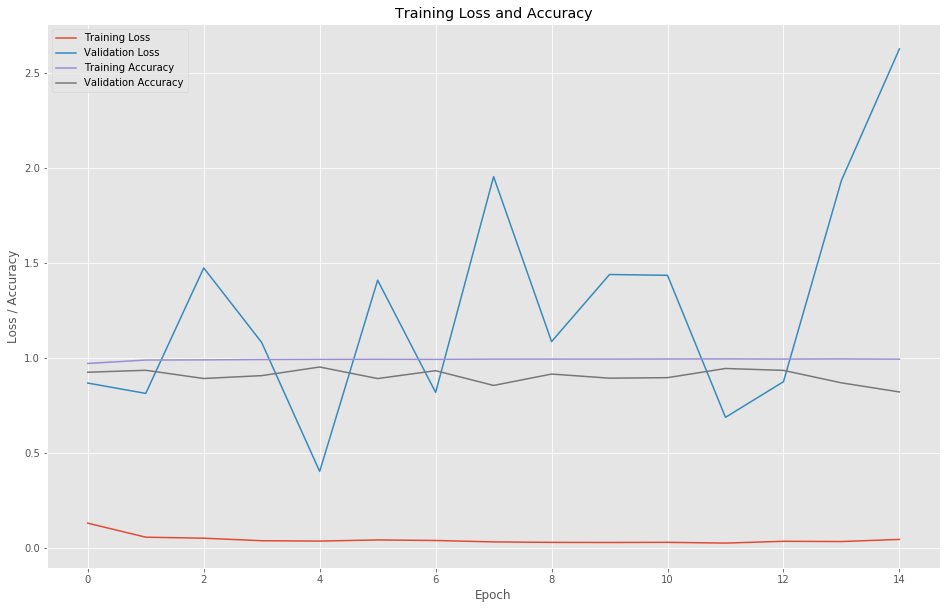

In [11]:
import matplotlib.pyplot as plt
import numpy as np

N = np.arange(0, len(H.history["acc"]))
plt.style.use("ggplot")
plt.figure(figsize=(16,10))
plt.plot(N, H.history["loss"], label="Training Loss")
plt.plot(N, H.history["val_loss"], label="Validation Loss")
plt.plot(N, H.history["acc"], label="Training Accuracy")
plt.plot(N, H.history["val_acc"], label="Validation Accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend()
plt.show()

In [10]:
model = keras.models.load_model('mobilenet_model.h5')

loss, accuracy = model.evaluate_generator(
    validation_generator,
    steps=validation_generator.samples / validation_generator.batch_size
)

print(f"Loss = {loss:0.5f}, Accuracy = {accuracy*100:0.2f}%")

Loss = 0.45382, Accuracy = 94.99%
